# Mon-Reader: Detecting Page Flipping, Text Extraction, and Speech Synthesis
This notebook covers the following workflow:
1. **Detect page flipping vs. still pages using CNNs** (ResNet, MobileNet, EfficientNet, and a custom Osama Net) on the provided image dataset.
2. **Extract text from detected still page frames** (future step, not implemented in this notebook).
3. **Synthesize speech from extracted text (TTS)** (future step, not implemented in this notebook).

## Notebook Outline
- Import Required Libraries (with GPU support)
- Load and Preprocess Dataset (images/training and images/testing, with flip/notflip subfolders)
- Prepare Data Generators (with augmentation)
- Build and Evaluate ResNet Model
- Build and Evaluate MobileNet Model
- Build and Evaluate EfficientNet Model
- Define and Train Custom CNN (Osama Net)
- Evaluate Osama Net on Test Set and Show Predictions
- Compare Model Accuracies and Analysis

# 1. Import Required Libraries and Enable GPU Support


In [6]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  

2.19.0
Num GPUs Available:  0


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Ensure TensorFlow uses GPU if available
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(physical_devices)}. Memory growth enabled.")
    except Exception as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected. Training will use CPU.")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Input,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

No GPU detected. Training will use CPU.


# 2. Load and Preprocess Dataset


In [8]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dir = "images/training"
test_dir = "images/testing"

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


# 3. Prepare Data Generators with Augmentation


In [9]:
aug_train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

aug_train_gen = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
)

Found 2392 images belonging to 2 classes.


# 4. Build and Evaluate ResNet Model


In [10]:
def build_resnet(input_shape):
    base_model = ResNet50(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


resnet_model = build_resnet((*IMG_SIZE, 3))
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
resnet_history = resnet_model.fit(
    aug_train_gen, epochs=10, validation_data=test_gen, callbacks=[early_stop]
)

resnet_eval = resnet_model.evaluate(test_gen)
print(f"ResNet Test Accuracy: {resnet_eval[1]:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 108s 1us/step


d:\Repositories\Apziva Projects\Project 4\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 563ms/step - accuracy: 0.5021 - loss: 0.7158 - val_accuracy: 0.5142 - val_loss: 0.6918
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.5238 - loss: 0.6978 - val_accuracy: 0.5142 - val_loss: 0.6906
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.4728 - loss: 0.7110 - val_accuracy: 0.5528 - val_loss: 0.6907
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.5103 - loss: 0.6983 - val_accuracy: 0.5410 - val_loss: 0.6894
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - accuracy: 0.5007 - loss: 0.6990 - val_accuracy: 0.5745 - val_loss: 0.6890
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.5078 - loss: 0.6960 - val_accuracy: 0.5310 - val_loss: 0.6884
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.5094 - loss: 0.6976 - val_accuracy: 0.5209 - val_loss: 0.6883
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.5235 - loss: 0.6932 - val_accu

# 5. Build and Evaluate MobileNet Model


In [11]:
def build_mobilenet(input_shape):
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


mobilenet_model = build_mobilenet((*IMG_SIZE, 3))
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
mobilenet_history = mobilenet_model.fit(
    aug_train_gen, epochs=10, validation_data=test_gen, callbacks=[early_stop]
)

mobilenet_eval = mobilenet_model.evaluate(test_gen)
print(f"MobileNet Test Accuracy: {mobilenet_eval[1]:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 404ms/step - accuracy: 0.5535 - loss: 0.7924 - val_accuracy: 0.7621 - val_loss: 0.4953
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 385ms/step - accuracy: 0.7310 - loss: 0.5204 - val_accuracy: 0.8275 - val_loss: 0.4169
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 387ms/step - accuracy: 0.7938 - loss: 0.4388 - val_accuracy: 0.8677 - val_loss: 0.3604
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 390ms/step - accuracy: 0.8457 - loss: 0.3759 - val_accuracy: 0.8777 - val_loss: 0.3302
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 385ms/step - accuracy: 0.8522 - loss: 0.3455 - val_accuracy: 0.8811 - val_loss: 0.2997
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.8484 - loss: 0.3308 - val_accuracy: 0.8945 - val_loss: 0.2842
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 386ms/step - accuracy: 0.8838 - loss: 0.2968 - val_accuracy: 0.8945 - val_loss: 0.2773
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 379ms

# 6. Build and Evaluate EfficientNet Model


In [12]:
def build_efficientnet(input_shape):
    base_model = EfficientNetB0(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


efficientnet_model = build_efficientnet((*IMG_SIZE, 3))
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
efficientnet_history = efficientnet_model.fit(
    aug_train_gen, epochs=10, validation_data=test_gen, callbacks=[early_stop]
)

efficientnet_eval = efficientnet_model.evaluate(test_gen)
print(f"EfficientNet Test Accuracy: {efficientnet_eval[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 426ms/step - accuracy: 0.4947 - loss: 0.6993 - val_accuracy: 0.5142 - val_loss: 0.6928
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 393ms/step - accuracy: 0.5169 - loss: 0.6937 - val_accuracy: 0.5142 - val_loss: 0.6928
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 387ms/step - accuracy: 0.5191 - loss: 0.6944 - val_accuracy: 0.5142 - val_loss: 0.6928
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.5124 - loss: 0.6951 - val_accuracy: 0.5142 - val_loss: 0.6929
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.1996 - loss: 0.7070
EfficientNet Test Accuracy: 0.5142


# 7. Define and Train Custom CNN (Osama Net)


In [13]:
def build_osama_net(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            Conv2D(32, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            BatchNormalization(),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(128, activation="relu"),
            Dropout(0.4),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


osama_net = build_osama_net((*IMG_SIZE, 3))
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
osama_history = osama_net.fit(
    aug_train_gen, epochs=20, validation_data=test_gen, callbacks=[early_stop]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 525ms/step - accuracy: 0.6655 - loss: 0.8247 - val_accuracy: 0.4858 - val_loss: 0.7669
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - accuracy: 0.8060 - loss: 0.4285 - val_accuracy: 0.4858 - val_loss: 4.2688
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 563ms/step - accuracy: 0.8445 - loss: 0.3519 - val_accuracy: 0.4858 - val_loss: 6.0394
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.8713 - loss: 0.2826 - val_accuracy: 0.4858 - val_loss: 8.1265
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 519ms/step - accuracy: 0.8636 - loss: 0.3035 - val_accuracy: 0.4858 - val_loss: 4.4861
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 509ms/step - accuracy: 0.8859 - loss: 0.2772 - val_accuracy: 0.4975 - val_loss: 2.4597


# Evaluate **Osama Net** on Test Set and Show Predictions


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.8004 - loss: 0.4448
Osama Net Test Accuracy: 0.4858


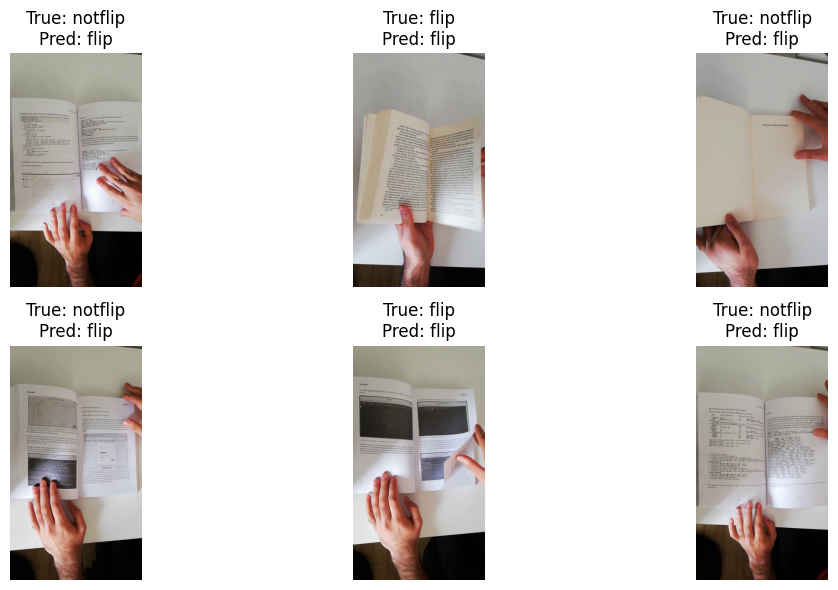

ResNet Test Accuracy: 0.6432
MobileNet Test Accuracy: 0.9062
EfficientNet Test Accuracy: 0.5142
Osama Net Test Accuracy: 0.4858


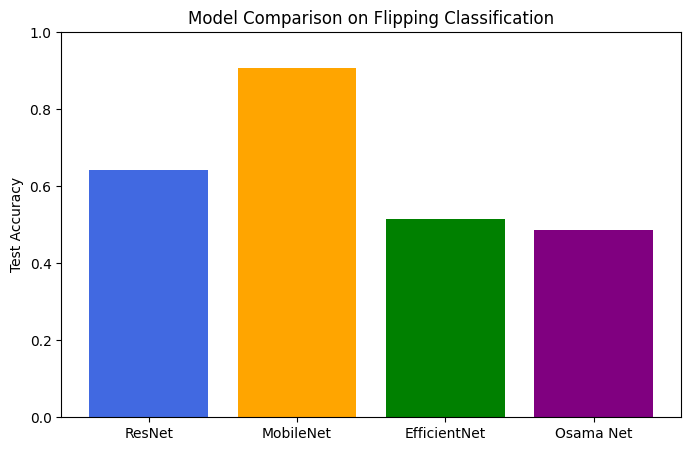

Analysis:
Compare the results above. The best model is the one with the highest test accuracy. Consider model complexity, training time, and overfitting when choosing the best architecture for this task.


In [14]:
osama_eval = osama_net.evaluate(test_gen)
print(f"Osama Net Test Accuracy: {osama_eval[1]:.4f}")

# Show sample predictions
class_labels = list(train_gen.class_indices.keys())
test_gen.reset()
preds = osama_net.predict(test_gen, verbose=0)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = test_gen.classes

indices = random.sample(range(len(true_labels)), 6)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    img_path = test_gen.filepaths[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(
        f"True: {class_labels[true_labels[idx]]}\nPred: {class_labels[pred_labels[idx]]}"
    )
    plt.axis("off")
plt.tight_layout()
plt.show()

# Compare Model Accuracies and Analysis
print(f"ResNet Test Accuracy: {resnet_eval[1]:.4f}")
print(f"MobileNet Test Accuracy: {mobilenet_eval[1]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_eval[1]:.4f}")
print(f"Osama Net Test Accuracy: {osama_eval[1]:.4f}")

accuracies = [resnet_eval[1], mobilenet_eval[1], efficientnet_eval[1], osama_eval[1]]
model_names = ["ResNet", "MobileNet", "EfficientNet", "Osama Net"]
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=["royalblue", "orange", "green", "purple"])
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Flipping Classification")
plt.ylim(0, 1)
plt.show()

# Analysis
print("Analysis:")
print(
    "Compare the results above. The best model is the one with the highest test accuracy. Consider model complexity, training time, and overfitting when choosing the best architecture for this task."
)